In [105]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier      
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler
import  matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap

shap.initjs()

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00


In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.7 MB/s eta 0:00:00


In [3]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
data = pd.read_csv('/content/data.csv')

In [44]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [45]:
data = data.replace({'is_bad_credit': {0:1, 1:0}})
data.rename(columns={'is_bad_credit': 'is_good_credit'}, inplace=True)

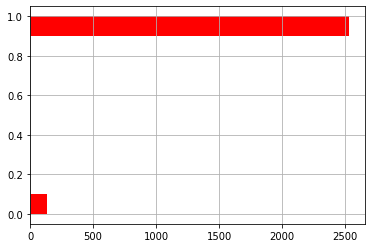

In [46]:
data['is_good_credit'].hist(orientation='horizontal', color='red')

In [47]:
data['sector'] = LabelEncoder().fit_transform(data['sector'])
data['marital_status'] = LabelEncoder().fit_transform(data['marital_status'])
data['district'] = LabelEncoder().fit_transform(data['district'])

In [48]:
X = data.drop(['is_good_credit'], axis = 1)
y = data['is_good_credit']

In [49]:
X_norm = MinMaxScaler().fit_transform(X) 

In [50]:
X_norm = pd.DataFrame(data = X_norm, columns = list(X.columns))

In [51]:
ovs = RandomOverSampler(random_state = 42)
X_res, y_res = ovs.fit_resample(X_norm, y)

In [52]:
from sklearn.utils import shuffle
X_res, y_res = shuffle(X_res, y_res)

In [53]:
X_res.reset_index(drop=True, inplace=True)
y_res.reset_index(drop=True, inplace=True)

In [54]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size = 0.25)

In [113]:
model_adc = AdaBoostClassifier()
model_adc.fit(X_train_res, y_train_res)

AdaBoostClassifier()

In [114]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier()

In [20]:
model_bc = BaggingClassifier()
model_bc.fit(X_train_res, y_train_res)

BaggingClassifier()

In [96]:
model_cbct = CatBoostClassifier()
model_cbct.fit(X_train_res, y_train_res)

Learning rate set to 0.01821
0:	learn: 0.6847127	total: 4.79ms	remaining: 4.78s
1:	learn: 0.6788201	total: 7.9ms	remaining: 3.94s
2:	learn: 0.6718248	total: 10.8ms	remaining: 3.58s
3:	learn: 0.6654535	total: 13.6ms	remaining: 3.39s
4:	learn: 0.6588627	total: 16.5ms	remaining: 3.29s
5:	learn: 0.6515381	total: 19.3ms	remaining: 3.19s
6:	learn: 0.6458377	total: 25.9ms	remaining: 3.67s
7:	learn: 0.6396080	total: 28.8ms	remaining: 3.57s
8:	learn: 0.6340775	total: 31.2ms	remaining: 3.44s
9:	learn: 0.6296337	total: 34ms	remaining: 3.36s
10:	learn: 0.6225308	total: 36.8ms	remaining: 3.31s
11:	learn: 0.6174441	total: 39.8ms	remaining: 3.27s
12:	learn: 0.6113988	total: 42.7ms	remaining: 3.24s
13:	learn: 0.6060940	total: 45.7ms	remaining: 3.22s
14:	learn: 0.6028322	total: 48.5ms	remaining: 3.18s
15:	learn: 0.5977377	total: 51.6ms	remaining: 3.17s
16:	learn: 0.5934861	total: 54.4ms	remaining: 3.15s
17:	learn: 0.5884794	total: 57.2ms	remaining: 3.12s
18:	learn: 0.5844229	total: 60.3ms	remaining: 3.

In [89]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_res, y_train_res)

LGBMClassifier()

In [58]:
model_xgb = xgb.XGBClassifier(
        learning_rate=0.1,     
        n_estimators=150,   
        max_depth= 9,
        min_child_weight= 5,
        gamma= 0.4,
        subsample= 0.9,
        colsample_bytree= 1,
        reg_alpha= 1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
model_xgb.fit(X_train_res, y_train_res)


XGBClassifier(gamma=0.4, max_depth=9, min_child_weight=5, n_estimators=150,
              nthread=4, reg_alpha=1e-05, seed=27, subsample=0.9)

In [91]:
def sum_plot(model_tr):
  shap_values = shap.TreeExplainer(model_tr).shap_values(X_res)
  return shap.summary_plot(shap_values, X_res)

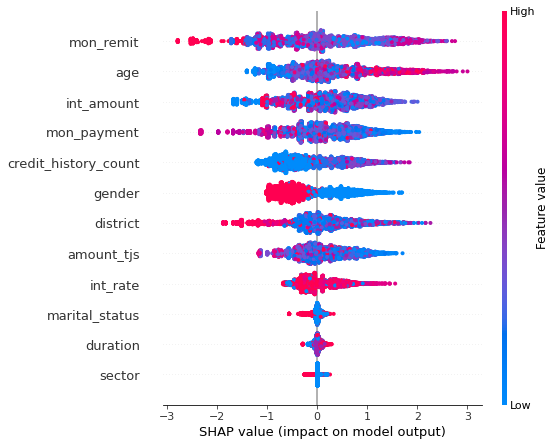

In [134]:
sum_plot(model_xgb)

In [93]:
def dep_plot(column, model_tr):
  shap_values = shap.TreeExplainer(model_tr).shap_values(X_res)
  return shap.dependence_plot(column, shap_values, X_res)


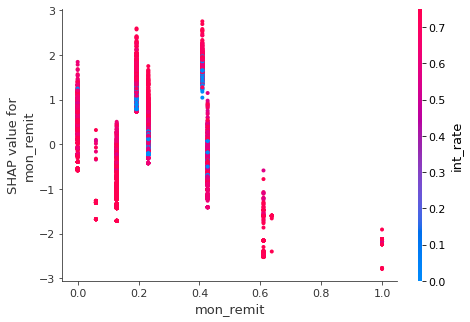

In [135]:
dep_plot('mon_remit', model_xgb)

In [101]:
def inter_plot(col_one, col_two, model_tr):
  shap_interaction_values = shap.TreeExplainer(model_tr).shap_interaction_values(X_res.iloc[:2000,:])
  return shap.dependence_plot(
      (col_one, col_two),
      shap_interaction_values, X_res.iloc[:2000,:],
      display_features=X_res.iloc[:2000,:]
     )

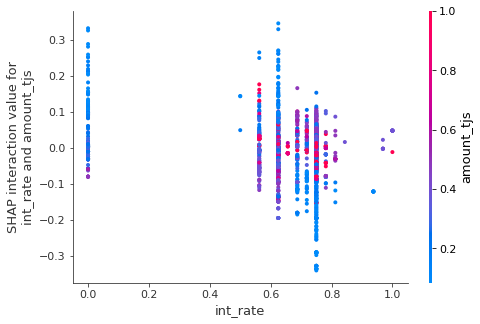

In [136]:
inter_plot('int_rate', 'amount_tjs', model_xgb)

In [103]:
def sm_plot(model_tr):
  shap_interaction_values = shap.TreeExplainer(model_tr).shap_interaction_values(X_res.iloc[:2000,:])
  return shap.summary_plot(shap_interaction_values, X_res.iloc[:2000,:])

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


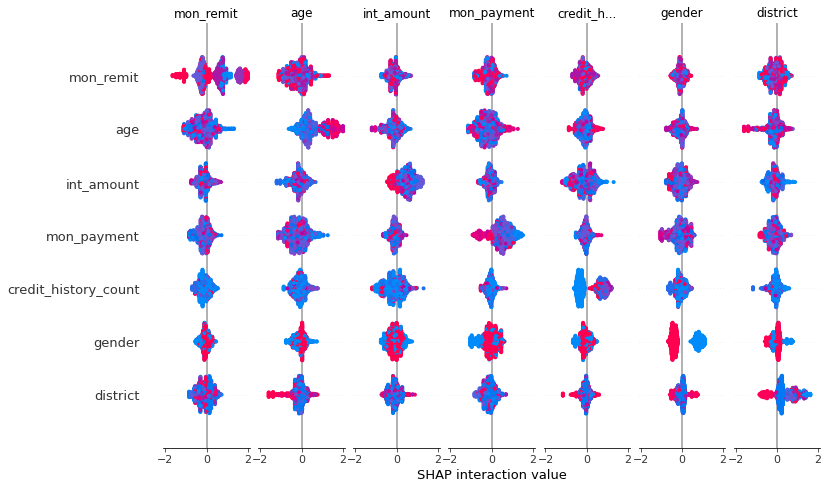

In [137]:
sm_plot(model_xgb)

In [106]:
def deci_plot(model_tr):
  explainer = shap.TreeExplainer(model_tr)
  expected_value = explainer.expected_value
  if isinstance(expected_value, list):
    expected_value = expected_value[1]
  

  select = range(20)
  features = X_res.iloc[select]
  features_display = X_res.loc[features.index]

  with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      shap_values = explainer.shap_values(features)[1]
      shap_interaction_values = explainer.shap_interaction_values(features)
  if isinstance(shap_interaction_values, list):
      shap_interaction_values = shap_interaction_values[1]

  return shap.decision_plot(expected_value, shap_values, features_display)    

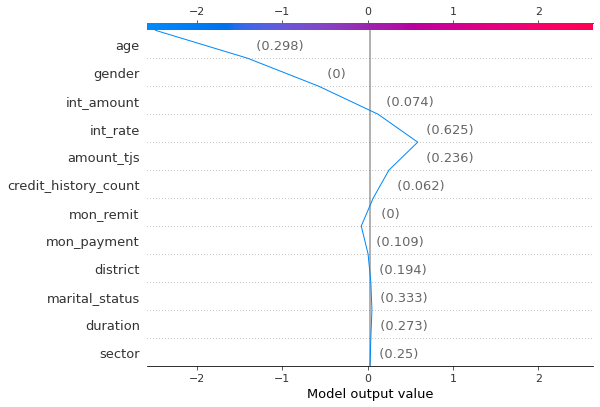

In [138]:
deci_plot(model_xgb)

In [129]:
def water_fall(model_tr, num):
  explainer = shap.Explainer(model_tr, X_res)
  shap_values = explainer(X_res)
  return shap.plots.waterfall(shap_values[num])

 99%|===================| 5018/5062 [00:51<00:00]       

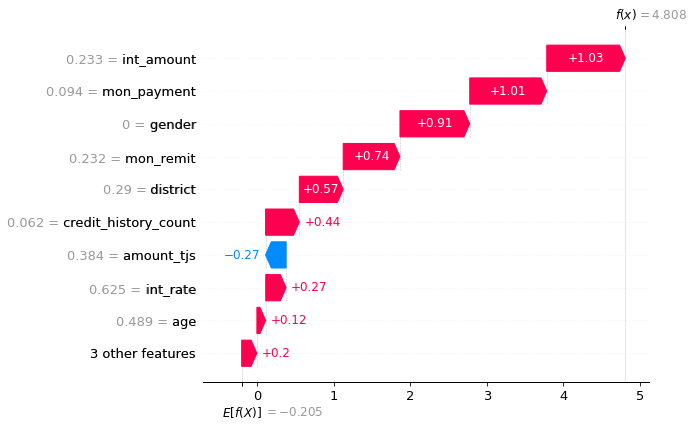

In [139]:
water_fall(model_xgb, 4)

In [131]:
def bar_plot(model_tr):
  explainer = shap.Explainer(model_tr, X_res)
  shap_values = explainer(X_res)
  return shap.plots.bar(shap_values)

 98%|===================| 4976/5062 [00:48<00:00]       

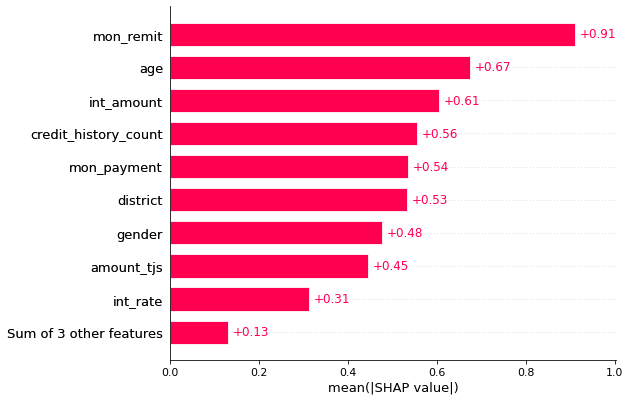

In [132]:
bar_plot(model_xgb)